# Part I - Wildfire Preprocessing
This is the **first** notebook in a series of 3 that will work through predicting wildfire incidence using historical wildfire, climatology, and land cover usage data. Both a spatial logistic regression and a neural network will be showcased.

Before we even pass our data through to any model, we must preprocess it. **The main issue surrounding our 3 datasets is format:**
- The wildfire data are **point** data, meaning for each wildfire that has occurred, we have the exact location it happened at. This is also housed in a SQLite database.
- The climatology data are **worldwide** at a specific resolution, which are referred to by their degrees. This data is box-like, and
  the various values we have are an average of the box.
- The land cover usage data is similar in resolution of the climatology data, but this is only for the continental United States.

We need to match the resolution given by all the datasets, so that when reading them later, all data shapes match. Since the land cover data is the most constrained, that will be the resolution we match.

## Resolutions
The terminology used is that of degree-minute-second. There 60 "minutes" in a single degree, and 60 "seconds" in a single minute. For example, an angle that is 5 "minutes" is 5/60 = **1/12 degrees**. As a gross approximation, this equates to about 5.76 miles on the surface. We have 4 resolutions in our data, **10 minutes, 5 minutes, 2.5 minutes, and 30 seconds.** The land cover data also has bounds on the latitude and longitude in order to contain the continental US. The bounding box is from $24.5\textdegree N$ to $50\textdegree N$ as latitude, and $-125\textdegree E$ to $-66.5\textdegree E$ as longitude.

## Import Packages
As always, we import all the packages we need first.

In [1]:
import os
import io
import datetime as dt
import sqlite3  # To read the wildfire database
import zipfile
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import rasterio as rio  # To read the land cover raster images
from rasterio.windows import Window

## Metadata
We also some other metadata, such as directory locations, the names of the metrics we will use, and the values of the bounding box.


In [2]:
ROOT = '../'
PREFIX = os.path.join(ROOT, 'data')
RAW_DATA_DIR = os.path.join(PREFIX, 'raw')
PROCESSED_DATA_DIR = os.path.join(PREFIX, 'processed')
# We have seven metrics to analyze
metrics = ['tmin', 'tmax', 'tavg', 'prec', 'srad',
           'wind', 'vapr']

# Bounding box, in degrees north and degrees east
LAT_MIN = 24.5
LAT_MAX = 50
LON_MIN = -125
LON_MAX = -66.5

## Preprocessing the 10-minute data
First, we'll walk through processing the 10-minute data. This is the most coarse resolution, and hence the smallest size. There are a few main steps here:
- Using the resolution and the bounding box, calculate what index correspond to the latitude and longitude values in the climatology images. Read just this portion for each metric.
- Download each metric's data, unzip them in memory, and extract the raster images to disk. This results in 12 images per metric, one for each month.
- Read the fire point data, calculate which "pixel" each latitude and longitude point it belongs in, and update the count at that location.
- Save all of them in NPY files!

### Calculating bounding box index
Recall that the climatology data is of the whole world, which means the latitude ranges from 90 (at index 0) to -90, and the longitude ranges from -180 (at index 0) to 180. 

**Note that the latitude is decreasing!** The effect of this is that our indices will be flipped. The smaller index will correspond to the _larger_ latitude value, and vice versa. The variable names will stay consistent.

We will create ae method to calculate the correct indices, and return them as a latitude longitude pair. It will take as input the bounding box values, as well as the resolution, in the form of the number of divisions per degree e.g. 6 for 10-minute resolution.

In [3]:
def convert_latlon_to_index(lat, lon, div_per_deg, LAT_MIN, LAT_MAX, LON_MIN, LON_MAX):
    # For latitude...
    if lat < LAT_MIN or lat >= LAT_MAX:
        raise ValueError(f"Latitude value of {lat} is out of range ({LAT_MIN}, {LAT_MAX}]!")
    lat_index = int((lat - LAT_MAX) * -div_per_deg)
    # Longitude...
    if lon < LON_MIN or lon >= LON_MAX:
        raise ValueError(f"Longitude value of {lon} is out of range ({LON_MIN}, {LON_MAX}]!")
    lon_index = int((lon - LON_MIN) * div_per_deg)
    return lat_index, lon_index

Now just pass in the full latitude longitude endpoints of (90, -90) and (-180, 180) along with the bounding box values.

In [4]:
clim_lat_min_i, clim_lon_min_i = convert_latlon_to_index(LAT_MIN, LON_MIN, 6, -90, 90, -180, 180)
clim_lat_max_i, clim_lon_max_i = convert_latlon_to_index(LAT_MAX, LON_MAX, 6, -90, 90, -180, 180)
print('Minimum lat lon index:', clim_lat_min_i, clim_lon_min_i)
print('Maximum lat lon index:', clim_lat_max_i, clim_lon_max_i)

Minimum lat lon index: 393 330
Maximum lat lon index: 240 681


Notice how the minimum latitude index is **larger** than the maximum latitude index. When slicing the worldwide data, we need to make sure we order it properly.

### Read land cover
Even though we have a bounding box, not all locations consist of land i.e. the box includes the water on the coasts. The land cover dataset have marked these locations as containing missing data. We need to read where these locations are, so that we can apply them across the climatology and fire datasets. Therefore, we can keep the areas of missing data the same across all the data we have. 

Although the land cover and the climatology datasets have the TIF extension, these are not traditional images, but instead are **raster** images. Additional data are contained in raster images, and most importantly for our case, we need the **mask** and the data value signifying missing data. Both the locations where the mask evaluates to `True` and where there are values signifying missing data are locations for NaN.

In [5]:
with rio.open(os.path.join(RAW_DATA_DIR, '10m', 'nlcd2013_10min.tif'), 'r') as lc:
    lc_data = lc.read(1).astype(float)  # NaN is considered as float, so we convert here
    no_data_val = lc.nodata
    lc_mask = ~lc.dataset_mask().astype(bool)  # By default, True is location WITH data, so we flip it
    # With land cover, the 0 value is also a case for NaNs.
    lc_nan_locs = (lc_data == no_data_val) | (lc_data == 0) | lc_mask
    lc_data[lc_nan_locs] = np.nan

In [6]:
print(lc_data)
print(lc_data.shape)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
(153, 351)


We see that the resulting shape is 153 by 351. For the 10-minute resolution, this is the shape we should force all the other datasets to be.
### Reading the metrics
Next, we will read all our metrics. There are a total of 7 metrics we will download and preprocess:
- `tavg` - average temperature
- `tmax` - maximum temperature
- `tmin` - minimum temperature
- `prec` - total precipitation
- `srad` - solar radiation
- `wind` - wind speeds
- `vapr` - amount of water vapor i.e. humidity

Each month is its own TIF raster image file, so we must read these individually and collate them in the end. I will go over the process for a single month's metric (January average temperature) and then we will create a loop around it.

#### January average temperature
The download URLs follow a set pattern, so we can download them on-the-fly. To avoid using up duplicate space, we will also create the zip file in memory itself, and extract directly to the file system, for example:

In [7]:
local_folder = 'wc2.1_10m_tavg'
download_url = f'http://biogeo.ucdavis.edu/data/worldclim/v2.1/base/{local_folder}.zip'
print(f'Downloading {local_folder}.zip and unzipping...', end='')
if not os.path.exists(os.path.join(RAW_DATA_DIR, '10m', local_folder)):
    # Download the zip file, and extract contents directly.
    r = requests.get(download_url, stream=True)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(os.path.join(RAW_DATA_DIR, '10m', local_folder))
print('Done')

The 12 TIF files will be under `data/raw/10m/wc2.1_10m_tavg/`. 

To read the January data, we use the `rasterio` package again. But this time, because we don't want to read the whole world, we use `rasterio.windows.Window`, and provide the row and column offset index, as well as the width and height to read. This prevents the entire data from being read into memory.
 
The row and column are given from the index bounds we calculated earlier, and the width and height are given by the difference in the indices. The other steps are similar to the land cover. **Recall that the latitude indices are flipped, so order accordingly!**

Finally, we also want to apply the combined mask of the climatology and the land cover to both datasets.

In [8]:
jan_tif_file = f'{local_folder}_01.tif'

with rio.open(os.path.join(RAW_DATA_DIR, '10m', local_folder, jan_tif_file), 'r') as data:
    # Windowed reading, find the range, given the latitude and longitude indices.
    width = clim_lon_max_i - clim_lon_min_i
    height = clim_lat_min_i - clim_lat_max_i  # min minus max!
    # Read the data, and save the data mask.
    data_array = data.read(1, window=Window(row_off=clim_lat_max_i, col_off=clim_lon_min_i,
                                            width=width, height=height))
    no_data_val = data.nodata
    # For the mask, we just use simple index slicing.
    data_mask = ~data.dataset_mask().astype(bool)[clim_lat_max_i: clim_lat_min_i, clim_lon_min_i: clim_lon_max_i]
    # Set appropriate locations in the array to NaN
    nan_locs = (data_array == no_data_val) | data_mask | lc_nan_locs
    data_array[nan_locs] = np.nan
    # Update the land cover as well!
    lc_data[nan_locs] = np.nan

print(data_array)
print('Shape:', data_array.shape)
# We can check for equality of the mask through an XNOR.
# Locations of differing values of the mask (True in one vs. False in the other)
# need to evaluate False. No False in the entire matrix means the masks are equal.
print('Climatology NaNs equal to land cover NaNs?', np.all(~(np.isnan(data_array) ^ np.isnan(lc_data))))

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Shape: (153, 351)
Climatology NaNs equal to land cover NaNs? True


And just like that, we have data for the average temperature in January! 

#### Average Temperature January Plot
We can plot it directly with `matplotlib`, and Python will automatically set the NaN locations to white. We also manually add a color bar, as `.imshow()` doesn't do that.

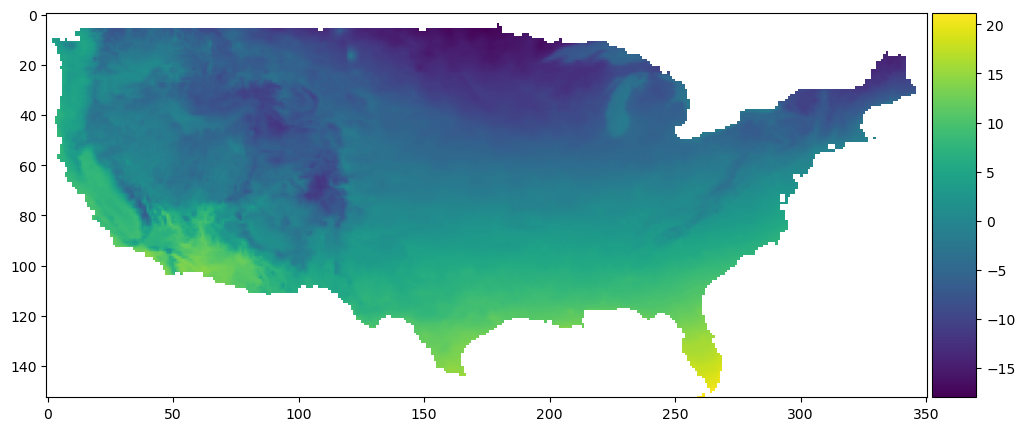

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(data_array)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.savefig(os.path.join(PREFIX, 'jan_tavg_10m.png'))
plt.show()

### All metrics and months
Now that we've seen how to read in one month's metric data, we can loop through both of them and read all of them at once. In order to concatenate each individual month's data, we use `np.stack()`. We also ensure to correctly calculate the combined mask at the end, using a combination of Numpy's logical functions and `.reduce()`.

In [10]:
for metric in metrics:
    print(f'-10m {metric.upper()}')
    local_folder = f'wc2.1_10m_{metric}'
    download_url = f'http://biogeo.ucdavis.edu/data/worldclim/v2.1/base/{local_folder}.zip'
    print(f'\t- Downloading {local_folder}.zip and unzipping...', end='')
    if not os.path.exists(os.path.join(RAW_DATA_DIR, local_folder)):
        # Download the zip file, save it directly as an object and extract into directory.
        r = requests.get(download_url, stream=True)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(os.path.join(RAW_DATA_DIR, '10m', local_folder))
    print('Done')

    # Next, we'll create a dictionary that will hold the data for each month.
    # We will unpack this later to save in a compressed npz file.
    # For reading the months, we will need to use rasterio.
    metric_data = []
    print('\t- Reading months...', end='')
    for i in range(1, 13):
        tif_file = f'{local_folder}_{i:02}.tif'
        with rio.open(os.path.join(RAW_DATA_DIR, '10m', local_folder, tif_file)) as data:
            # Windowed reading, find the range, given the latitude and longitude indices.
            # Because latitudes decrease as index increase, flip the min and max.
            width = clim_lon_max_i - clim_lon_min_i
            height = clim_lat_min_i - clim_lat_max_i
            # Read the data, and also save the data mask
            # Remember to start at max lat index, not the minimum.
            data_array = data.read(1, window=Window(col_off=clim_lon_min_i, row_off=clim_lat_max_i,
                                                    width=width, height=height)).astype(float)
            no_data_val = data.nodata
            data_mask = ~data.dataset_mask().astype(bool)[clim_lat_max_i: clim_lat_min_i, clim_lon_min_i: clim_lon_max_i]
            # Set appropriate locations in the array to NaN
            nan_locs = (data_array == no_data_val) | data_mask
            data_array[nan_locs] = np.nan
            # Append to our data array...
            metric_data.append(data_array)
    # Stack them all to create a matrix of (12, resolution)
    metric_data = np.stack(metric_data)
    # Any locations where EITHER the land cover is NaN or the metrics are NaNs
    # should be NaN in both. Use logical_or to calculate NaNs for all the months.
    complete_nan_locs = np.logical_or.reduce(np.isnan(metric_data))
    metric_lc_nan_locs = np.logical_or(complete_nan_locs, np.isnan(lc_data))
    # Set it for our metric by broadcasting the result of np.where across all months.
    metric_data[:, *np.where(metric_lc_nan_locs)] = np.nan
    # Update NaNs in land cover
    lc_data[np.where(metric_lc_nan_locs)] = np.nan
    print('Done')

    # SAVE THE METRIC AND LAND COVER under the processed directory.
    print(f'\t- Uploading {metric}...', end='')
    os.makedirs(os.path.join(PROCESSED_DATA_DIR, '10m'), exist_ok=True)
    np.save(os.path.join(PROCESSED_DATA_DIR, '10m', f'{metric}.npy'), metric_data)
    print('Done')

-10m TMIN
	- Downloading wc2.1_10m_tmin.zip and unzipping...Done
	- Reading months...Done
	- Uploading tmin...Done
-10m TMAX
	- Downloading wc2.1_10m_tmax.zip and unzipping...Done
	- Reading months...Done
	- Uploading tmax...Done
-10m TAVG
	- Downloading wc2.1_10m_tavg.zip and unzipping...Done
	- Reading months...Done
	- Uploading tavg...Done
-10m PREC
	- Downloading wc2.1_10m_prec.zip and unzipping...Done
	- Reading months...Done
	- Uploading prec...Done
-10m SRAD
	- Downloading wc2.1_10m_srad.zip and unzipping...Done
	- Reading months...Done
	- Uploading srad...Done
-10m WIND
	- Downloading wc2.1_10m_wind.zip and unzipping...Done
	- Reading months...Done
	- Uploading wind...Done
-10m VAPR
	- Downloading wc2.1_10m_vapr.zip and unzipping...Done
	- Reading months...Done
	- Uploading vapr...Done


In [11]:
metric_data.shape

(12, 153, 351)

Looking quickly at once of the metrics, we have a shape of 12 x 153 x 351, and that should make sense!

### Fires
Finally, we have the historical wildfire incidence data. Since this is in a database, and the query is simple (we are just grabbing all the rows), we can use `pandas.read_sql_query()` to save all the rows as a `DataFrame`. Each row constitutes a single fire observation, along with its apparent size, date, and latitude longitude location.

We initialize a fire matrix the same size as the climatology data (12 by 153 by 351) with all 0s. Then, for each observed fire, we calculate which cell is goes into using the location, and increment that count by 1. At the end, we will essentially have a fire frequency matrix.

Since we are dealing with the continental United States, we *will not* count fires from Alaska, Hawaii, and Puerto Rico. Additionally, we also won't count fires that are of size class A or B, as these fires are incredibly small, and will provide noise in our dataset.

In [12]:
db_file = os.path.join(PREFIX, 'FPA_FOD_20170508.sqlite')
# Just a simple query. The table is called Fires.
query = """
      SELECT FIRE_YEAR, DISCOVERY_DOY, STATE, LATITUDE, LONGITUDE, FIRE_SIZE_CLASS
      FROM Fires
    """
# Establish the connection
connection = sqlite3.connect(db_file)
fires_df = pd.read_sql_query(query, connection)
connection.close()

fires_df

,FIRE_YEAR,DISCOVERY_DOY,STATE,LATITUDE,LONGITUDE,FIRE_SIZE_CLASS
0,2005,33,CA,40.036944,-121.005833,A
1,2004,133,CA,38.933056,-120.404444,A
2,2004,152,CA,38.984167,-120.735556,A
3,2004,180,CA,38.559167,-119.913333,A
4,2004,180,CA,38.559167,-119.933056,A
...,...,...,...,...,...,...
1880460,2015,269,CA,40.481637,-122.389375,A
1880461,2015,278,CA,37.617619,-120.938570,A
1880462,2015,122,CA,37.617619,-120.938570,A
1880463,2015,287,CA,37.672235,-120.898356,B


We do not have a month column; rather, we have `DISCOVER_DOY`, which is the number day since the start of the year. It will be 1-365, except for leap years when it's 1-366. We can use the `datetime` package to calculate the actual date, and this also automatically takes care of leap years. 

To find the corresponding latitude and longitude index, we will invoke the `convert_latlon_to_index` method we created earlier.

In [17]:
# Initialize the fire dataset with 0s, and calculate the size.
height = int((LAT_MAX - LAT_MIN) * 6)
width = int((LON_MAX - LON_MIN) * 6)
fires = np.zeros((12, height, width), dtype=np.float32)

for row in fires_df.itertuples(index=False):
    # Extract the information
    year, day, state, lat, lon, size_class = row
    # If the state is Alaska (AK), Hawaii (HI) or Puerto Rico (PR), then skip it
    # Also ignore fires of size class A or B, these are really small fires.
    if state in ['AK', 'HI', 'PR'] or size_class in ['A', 'B']:
        continue
    # Create a data object for the first day of the year, and add the proper
    # number of days according to day.
    # These are 1-indexed so we add one less.
    # Then grab the month...which is also 1-indexed.
    # Leap years are already take into account with the package...
    fire_month = (dt.date(year, 1, 1) + dt.timedelta(days=day - 1)).month

    # Calculate the correct latitude and longitude,
    # and update the count of the fires at that location.
    lat_index, lon_index = convert_latlon_to_index(lat, lon, 6, LAT_MIN, LAT_MAX, LON_MIN, LON_MAX)
    fires[fire_month - 1, lat_index, lon_index] += 1
    
# Don't forget to update NaNs!
fires[:, *np.where(np.isnan(data_array))] = np.nan
np.save(os.path.join(PROCESSED_DATA_DIR, '10m', 'fires.npy'), fires)

In [14]:
fires.shape

(12, 153, 351)

In [15]:
np.sum(fires)

268042.0

Although the full fire table has 1.8 million fires, once we remove the very small fires, we are left with around 268 thousand.

And that's it! With that, all of land cover, the 7 climatology matrices, and the fire dataset all have the same mask at the same resolution. The only remaining step is to run these same processing steps for the remaining resolutions.

## Preprocessing everything
The solution is simple, we just place all the code above into a single loop. We keep track of the resolution, and how many divisions there are per degree. There will be a noticeable slowdown as move to finer resolutions, due to the size of the files we are downloading, so please be advised.

In [19]:
resolutions = ['5m', '2.5m', '30s']
divs_per_deg = [12, 24, 120]
land_cover_files = {
    '10m': 'nlcd2013_10min.tif',
    '5m': 'nlcd2013_5min.tif',
    '2.5m': 'nlcd2013_2pt5min.tif',
    '30s': 'nlcd2013_30sec.tif'
}
# List of tuples corresponding to climatology indices...
# The method returns a 2-tuple, so we simply concatenate them together.
# The result is a 4-tuple of lat_min_index, lon_min_index, lat_max_index, and lon_max_index.
climate_indices = [
    convert_latlon_to_index(LAT_MIN, LON_MIN, divs, -90, 90, -180, 180) +
    convert_latlon_to_index(LAT_MAX, LON_MAX, divs, -90, 90, -180, 180)
    for divs in divs_per_deg
]
# Create directories if not already present...
for res in resolutions:
    os.makedirs(os.path.join(RAW_DATA_DIR, res), exist_ok=True)
    os.makedirs(os.path.join(PROCESSED_DATA_DIR, res), exist_ok=True)

for res, divs, (LAT_MIN_IDX, LON_MIN_IDX, LAT_MAX_IDX, LON_MAX_IDX) in (
        zip(resolutions, divs_per_deg, climate_indices)):
    # Read the land cover so that we get the correct mask.
    with rio.open(os.path.join(RAW_DATA_DIR, res, land_cover_files[res]), 'r') as lc:
        lc_data = lc.read(1).astype(float)
        no_data_val = lc.nodata
        lc_mask = ~lc.dataset_mask().astype(bool)
        # With land cover, 0 is also a case for NaNs.
        lc_nan_locs = (lc_data == no_data_val) | (lc_data == 0) | lc_mask
        lc_data[lc_nan_locs] = np.nan

    # Now then, loop over all the metrics, and generate a matrix of
    # (12, <RESOLUTION>). This is the array we'll save.
    for metric in metrics:
        print(f'-{res} {metric.upper()}')
        local_folder = f'wc2.1_{res}_{metric}'
        download_url = f'http://biogeo.ucdavis.edu/data/worldclim/v2.1/base/{local_folder}.zip'
        print(f'\t- Downloading {local_folder}.zip and unzipping...', end='')
        if not os.path.exists(os.path.join(RAW_DATA_DIR, res, local_folder)):
            # Download the zip file, save it directly as an object and extract into directory.
            r = requests.get(download_url, stream=True)
            z = zipfile.ZipFile(io.BytesIO(r.content))
            z.extractall(os.path.join(RAW_DATA_DIR, res, local_folder))
        print('Done')

        # Next, we'll create a dictionary that will hold the data for each month.
        # We will unpack this later to save in a compressed npz file.
        # For reading the months, we will need to use rasterio.
        metric_data = []
        print('\t- Reading months...', end='')
        for i in range(1, 13):
            tif_file = f'{local_folder}_{i:02}.tif'
            with rio.open(os.path.join(RAW_DATA_DIR, res, local_folder, tif_file)) as data:
                # Windowed reading, find the range, given the latitude and longitude indices.
                # Because latitudes decrease as index increase, flip the min and max.
                width = LON_MAX_IDX - LON_MIN_IDX
                height = LAT_MIN_IDX - LAT_MAX_IDX
                # Read the data, and also save the data mask
                # Remember to start at max lat index, not the minimum.
                data_array = data.read(1, window=Window(col_off=LON_MIN_IDX, row_off=LAT_MAX_IDX,
                                                        width=width, height=height)).astype(float)
                no_data_val = data.nodata
                data_mask = ~data.dataset_mask().astype(bool)[LAT_MAX_IDX: LAT_MIN_IDX, LON_MIN_IDX: LON_MAX_IDX]
                # Set appropriate locations in the array to NaN
                nan_locs = (data_array == no_data_val) | data_mask
                data_array[nan_locs] = np.nan
                # Append to our data array...
                metric_data.append(data_array)
        # Stack them all to create a matrix of (12, resolution)
        metric_data = np.stack(metric_data)
        # Any locations where EITHER the land cover is NaN or the metrics are NaNs
        # should be NaN in both. Use logical_or to calculate NaNs for all the months.
        complete_nan_locs = np.logical_or.reduce(np.isnan(metric_data))
        metric_lc_nan_locs = np.logical_or(complete_nan_locs, np.isnan(lc_data))
        # Set it for our metric by broadcasting the result of np.where across all months.
        metric_data[:, *np.where(metric_lc_nan_locs)] = np.nan
        # Update NaNs in land cover
        lc_data[np.where(metric_lc_nan_locs)] = np.nan
        print('Done')

        # SAVE THE METRIC AND LAND COVER under the processed directory.
        print(f'\t- Uploading {metric}...', end='')
        np.save(os.path.join(PROCESSED_DATA_DIR, res, f'{metric}.npy'), metric_data)
        print('Done')

    # Establish a connection with the SQLite database file
    connection = sqlite3.connect(db_file)
    fires_df = pd.read_sql_query(query, connection)
    connection.close()

    # First, initialize the fire dataset with 0s
    # Calculate the size of the fire dataset
    height = int((LAT_MAX - LAT_MIN) * divs)
    width = int((LON_MAX - LON_MIN) * divs)
    print(width, height)
    # Create a 2d array
    fires = np.zeros((12, height, width), dtype=np.float32)
    
    for row in fires_df.itertuples(index=False):
        # Extract the information
        year, day, state, lat, lon, size_class = row
        # If the state is Alaska (AK), Hawaii (HI) or Puerto Rico (PR), then skip it
        # Also ignore fires of size class A or B, these are really small fires.
        if state in ['AK', 'HI', 'PR'] or size_class in ['A', 'B']:
            continue
        # Create a data object for the first day of the year, and add the proper
        # number of days according to day.
        # These are 1-indexed so we add one less.
        # Then grab the month...which is also 1-indexed.
        # Leap years are already take into account with the package...
        fire_month = (dt.date(year, 1, 1) + dt.timedelta(days=day - 1)).month
    
        # Calculate the correct latitude and longitude,
        # and update the count of the fires at that location.
        lat_index, lon_index = convert_latlon_to_index(lat, lon, divs, LAT_MIN, LAT_MAX, LON_MIN, LON_MAX)
        fires[fire_month - 1, lat_index, lon_index] += 1
        
    # Don't forget to update NaNs!
    fires[:, *np.where(np.isnan(data_array))] = np.nan

    # Apply the same mask as the climatology and land cover.
    # NaNs have been continuously updated in the lc_data as processed the metrics,
    # so grab it from there.
    np.save(os.path.join(PROCESSED_DATA_DIR, res, 'fires.npy'), fires)

    # Finally, save the land cover data (which might have updated NaNs)
    np.save(os.path.join(PROCESSED_DATA_DIR, res, 'lc.npy'), lc_data)

-5m TMIN
	- Downloading wc2.1_5m_tmin.zip and unzipping...Done
	- Reading months...Done
	- Uploading tmin...Done
-5m TMAX
	- Downloading wc2.1_5m_tmax.zip and unzipping...Done
	- Reading months...Done
	- Uploading tmax...Done
-5m TAVG
	- Downloading wc2.1_5m_tavg.zip and unzipping...Done
	- Reading months...Done
	- Uploading tavg...Done
-5m PREC
	- Downloading wc2.1_5m_prec.zip and unzipping...Done
	- Reading months...Done
	- Uploading prec...Done
-5m SRAD
	- Downloading wc2.1_5m_srad.zip and unzipping...Done
	- Reading months...Done
	- Uploading srad...Done
-5m WIND
	- Downloading wc2.1_5m_wind.zip and unzipping...Done
	- Reading months...Done
	- Uploading wind...Done
-5m VAPR
	- Downloading wc2.1_5m_vapr.zip and unzipping...Done
	- Reading months...Done
	- Uploading vapr...Done
702 306
-2.5m TMIN
	- Downloading wc2.1_2.5m_tmin.zip and unzipping...Done
	- Reading months...Done
	- Uploading tmin...Done
-2.5m TMAX
	- Downloading wc2.1_2.5m_tmax.zip and unzipping...Done
	- Reading months

KeyboardInterrupt: 

## Conclusion
With this, we have preprocessed all the data we have on hand. The next step is finally to move forward with the spatial logistic regression. There will actually be extra processing needed in order to format the matrix of values for model ingestion. Like with this notebook, we will work our way up from the most coarse resolution to the finest.